In [1]:
from models.encoder import COMET_Classifier, QCLR_Classifier
from tasks.fine_tuning import finetune_eval
from config_files.PTB_Configs import Config as Configs
import pickle
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from utils import seed_everything

Train set size: 37140 6098 31347
Train set size: 12380 2032 10473
Train set size: 12850 2030 10820
The program will run on cuda!


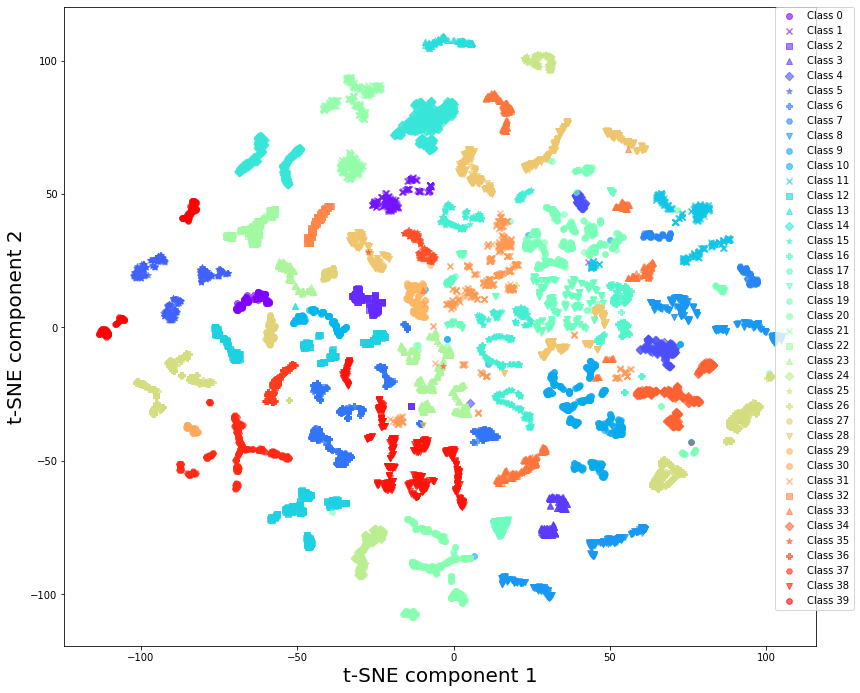

(12850,)
(12850,)
adjusted_rand_score (ARI):  0.36296526610469
normalized_mutual_info_score (NMI):  0.6751125819754286
silhouette_score:  0.1518984


In [2]:
configs = Configs()
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

RANDOM_SEED = configs.RANDOM_SEED
seed_everything(RANDOM_SEED)

with open('PTB_Fold1.pkl', 'rb') as f:
    fold_data = pickle.load(f)

print("Train set size:", len(fold_data['X_train']), (fold_data['y_train']==0).sum(), (fold_data['y_train']==1).sum())
print("Train set size:", len(fold_data['X_val']), (fold_data['y_val']==0).sum(), (fold_data['y_val']==1).sum())
print("Train set size:", len(fold_data['X_test']), (fold_data['y_test']==0).sum(), (fold_data['y_test']==1).sum())

X_train = fold_data['X_train']
X_val = fold_data['X_val']
X_test = fold_data['X_test']
y_train = fold_data['y_train']
y_val = fold_data['y_val']
y_test = fold_data['y_test']

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")

finetune_model = COMET_Classifier(input_dims=configs.input_dims,
                                  output_dims=configs.output_dims,
                                  depth=configs.depth,
                                  p_output_dims=configs.num_classes, device=device,
                                  flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.load_state_dict(torch.load("COMET_model.pt"))

unique_values = np.unique(y_test[:, 1])
label_mapping = {val: idx for idx, val in enumerate(unique_values)}
class_labels = np.array([label_mapping[val] for val in y_test[:, 1]])
y_emb_all, y_target, y_pred = finetune_eval(finetune_model, X_test,
                                            class_labels,
                                            num_classes=len(unique_values))

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

y_emb_all_np = y_emb_all.numpy()
y_target_np = y_target.numpy()
y_pred_np = y_pred.numpy()
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
y_emb_tsne = tsne.fit_transform(y_emb_all_np)
plt.figure(figsize=(12, 10))

from matplotlib import cm
from itertools import cycle
classes = np.unique(y_target_np[:])
colors = cm.rainbow(np.linspace(0, 1, len(classes[:])))
markers = cycle(['o', 'x', 's', '^', 'D', '*', 'P', 'H', 'v', '8'])
for i, class_label in enumerate(classes):
    indices = np.where(y_target_np[:] == class_label)
    plt.scatter(y_emb_tsne[indices, 0], y_emb_tsne[indices, 1],
                label=f'Class {class_label}',
                alpha=0.6,
                color=colors[i],
                marker=next(markers))

plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xlabel('t-SNE component 1', fontsize=20)
plt.ylabel('t-SNE component 2', fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

from sklearn.metrics import silhouette_score, davies_bouldin_score, \
    calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

n_clusters = 40  # number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
labels = kmeans.fit_predict(y_emb_all_np)

print(labels.shape)
print(y_target_np.shape)
score = adjusted_rand_score(y_target_np, labels)
print('adjusted_rand_score (ARI): ', score)
score = normalized_mutual_info_score(y_target_np, labels)
print('normalized_mutual_info_score (NMI): ', score)
score = silhouette_score(y_emb_all_np, labels)
print('silhouette_score: ', score)
score = davies_bouldin_score(y_emb_all_np, labels)


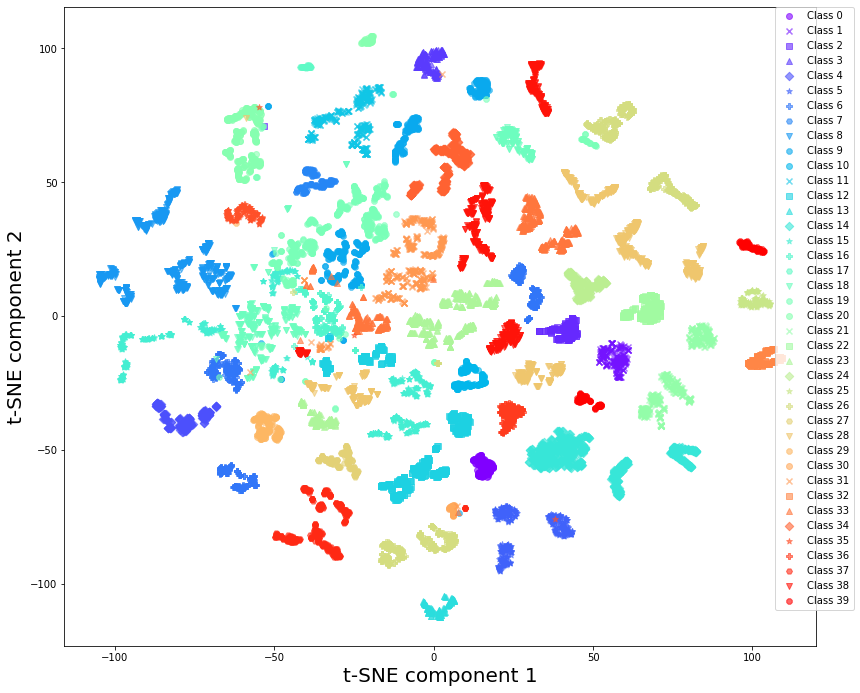

(12850,)
(12850,)
adjusted_rand_score (ARI):  0.3813074515827724
normalized_mutual_info_score (NMI):  0.6923831883374586
silhouette_score:  0.21611811


In [3]:
finetune_model = QCLR_Classifier(input_dims=configs.input_dims,
                              output_dims=configs.output_dims,
                              depth=configs.depth,
                              p_output_dims=configs.num_classes, device=device,
                              flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.load_state_dict(torch.load("QCLR_model.pt"))

unique_values = np.unique(y_test[:, 1])
label_mapping = {val: idx for idx, val in enumerate(unique_values)}
class_labels = np.array([label_mapping[val] for val in y_test[:, 1]])
y_emb_all, y_target, y_pred = finetune_eval(finetune_model, X_test,
                                            class_labels,
                                            num_classes=len(unique_values))

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

y_emb_all_np = y_emb_all.numpy()
y_target_np = y_target.numpy()
y_pred_np = y_pred.numpy()
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
y_emb_tsne = tsne.fit_transform(y_emb_all_np)
plt.figure(figsize=(12, 10))

from matplotlib import cm
from itertools import cycle
classes = np.unique(y_target_np[:])
colors = cm.rainbow(np.linspace(0, 1, len(classes[:])))
markers = cycle(['o', 'x', 's', '^', 'D', '*', 'P', 'H', 'v', '8'])
for i, class_label in enumerate(classes):
    indices = np.where(y_target_np[:] == class_label)
    plt.scatter(y_emb_tsne[indices, 0], y_emb_tsne[indices, 1],
                label=f'Class {class_label}',
                alpha=0.6,
                color=colors[i],
                marker=next(markers))

plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xlabel('t-SNE component 1', fontsize=20)
plt.ylabel('t-SNE component 2', fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

from sklearn.metrics import silhouette_score, davies_bouldin_score, \
    calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

n_clusters = 40  # number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
labels = kmeans.fit_predict(y_emb_all_np)

print(labels.shape)
print(y_target_np.shape)
score = adjusted_rand_score(y_target_np, labels)
print('adjusted_rand_score (ARI): ', score)
score = normalized_mutual_info_score(y_target_np, labels)
print('normalized_mutual_info_score (NMI): ', score)
score = silhouette_score(y_emb_all_np, labels)
print('silhouette_score: ', score)
score = davies_bouldin_score(y_emb_all_np, labels)